In [ ]:
# Only needed to run this cell for initial setup
!pip install pgspecial
!pip install psycopg2

In [10]:
import sqlalchemy

# create a local postgres database called "census"
u = input("Enter username:")
p = input("Enter password:")

connection = psycopg2.connect(host="localhost", dbname="census", user=u, password = p)
cur = connection.cursor()
cur.execute("""
        Create Table census(
          age Integer not null,
          workclass varchar null,
          fnlwgt Integer not null,
          education varchar not null,
          education_num Integer not null,
          marital_status varchar not null,
          occupation varchar null,
          relationship varchar not null,
          race varchar not null,
          sex varchar not null,
          capital_gain Integer not null, 
          capital_loss Integer not null,
          hours_per_week Integer not null,
          native_country varchar null,
          income varchar not null
          )
    """)
connection.commit()




Enter username:postgres
Enter password:password


In [ ]:
# After running the cell above, populate the census table locally
# \copy Census from file_location CSV

In [14]:
# fetch a sample of our data to make sure it populated properly
cur.execute("select * from Census")
print(cur.fetchone())


(39, ' State-gov', 77516, ' Bachelors', 13, ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', 2174, 0, 40, ' United-States', ' <=50K')


In [16]:
#Define Married and Unmarried Views:

query = """
Create or replace view married as 
    Select * from census where marital_status in (' Married-civ-spouse', ' Married-spouse-absent' ,' Married-AF-spouse');

Create or replace view unmarried as
    Select * from census where marital_status in (' Never-married', ' Widowed', ' Divorced', ' Separated');
"""

cur.execute(query)
connection.commit()

In [68]:
# define imports and user info

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import psycopg2
from scipy.special import kl_div as kl
%matplotlib inline 
plt.rcParams["figure.figsize"] = (12, 6)

u = input("Enter username:")
p = input("Enter password:")

Enter username:postgres
Enter password:password


In [141]:
#Define Helper Functions


#Please read the paper and understand the overall approach and evaluation methodology. 
#In particular, implement the algorithm based on the definition in Section 2, 
#Shared-based Optimization (through query rewriting) in Section 4.1, 
#and Pruning-based Optimization (using Hoeffding-Serfling inequality) in Section 4.2. 
#In evaluation, use the census data set. 
#Set the user-specified query to include the married people, 
#and the reference query to include unmarried people. 
#Use the K-L Divergence as the utility measure. 
#Find top-5 aggregate views by the utility measure. The plots should look like those illustrated in Figure 1.



connection = psycopg2.connect(host="localhost", dbname="census", user=u, password = p)
cur = connection.cursor()

# visualizes target vs ref query over a set of param attributes/aggregates
# target is a dict of query results from the target query
# ref is a dict of query results from the reference query
# params is a tuple of form (grp_by_attr, msr_attr, agg_func) used for plot labels
def visualize(target, ref, params):
    
    bars = len(target)
    grp_by_attr, msr_attr, agg_func = params
    
    figure, _ = plt.subplots()
    idx = np.arange(bars)
    width = 0.4
    
    target_vals = target.values()
    ref_vals = ref.values()
    
    first_bars = plt.bar(idx, target_vals, width,
                     color='m',
                     label='married')

    second_bars = plt.bar(idx + width, ref_vals, width,
                     color='b',
                     label='unmarried')

    plt.xlabel('{}'.format(grp_by_attr))
    plt.ylabel('{}({})'.format(agg_func, msr_attr))
    plt.xticks(idx + width/2, target.keys(), rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
#helper function to take in a view and list of tables and run the query to visualize
def calc_visualize(view, tables):
    a, m, f = view
    p = tables[0]
    q = tables[1]
    tgt_qry = "Select {}, {}({}) from {} Group by {}".format(a, f, m, p, a)
    cur.execute(tgt_qry)
    target_data = cur.fetchall()
    
    ref_qry = "Select {}, {}({}) from {} Group by {}".format(a, f, m, q, a)
    cur.execute(ref_qry)
    ref_data = cur.fetchall()
    
    visualize(dict(target_data), dict(ref_data), view)
    
    

# helper function to handle implementing the shared-based optimization
# takes a list of views of the form
def share_optimize(views, tables):

    select_text = []
    measure_text = []
    group_by_text = []
    
    for idx, (a, m, f) in enumerate(views):
        select_text.append(a)
        measure_text.append('{}({}) as g{}'.format(f, m, idx))
        group_by_text.append('({})'.format(a))
        
    select_text = ', '.join(set(select_text))
    measure_text = ', '.join(measure_text)
    group_by_text = ', '.join(set(group_by_text))
    
    res = []
    for table in tables:
        q = """select {}, {} from {} group by grouping sets ({})""".format(select_text, measure_text, table, group_by_text)
        cur.execute(q)
        res.append(cur.fetchall())
    column_descriptions = [desc[0] for desc in cur.description]
    
    return res, column_descriptions

# helper function to calculate kl_divergence of a target distribution p from a reference distribution q
def kl_divergence(p, q):
    p = np.asarray(p.reshape(-1), dtype=float)
    q = np.asarray(q.reshape(-1), dtype=float)
    
    #avoid division by 0
    if np.sum(p) > 0 and np.sum(q) > 0:
        p_prob = p/np.sum(p)
        q_prob = q/np.sum(q)
        return np.sum(kl(p_prob, q_prob))
    else:
        return 0.0
    
# helper function to prune uninteresting views
# takes a dict of {(a,m,f,t):[Y_1,Y_2,...,Y_i]}: phased utility measure estimates Y_i for ith phase
# phase: int 0<phase<=n for n-phase execution (default n=10)
# maxphase: n from above
# delta: confidence level is 1-delta, so 0.05 for 95% confint
# k: top k, def 5.
def prune_optimize(viewsInRunning, phase, maxphase=10,delta=0.05, k=5):
    
    view_stats = {}
    topk_views = {key:0 for key in range(k)} # initializing with zeros, only stores upper bounds
    
    # Calculating confidence intervals and bounds
    for view,estimates in viewsInRunning.items():
        err_bound = np.sqrt((1-(phase-1)/maxphase)*(2*np.log(np.log(phase))) + np.log((np.pi**2)/(3*delta)))
        mean = np.mean(estimates)
        upp_bound = mean + err_bound
        low_bound = mean - err_bound
        view_stats[view] = (low_bound,mean,upp_bound)
        # Track top K views
        if upp_bound > min(topk_views.values()):
            # remove the lowest view, and add the new one
            topk_views = {k:v for k,v in topk_views.items() if v != min(topk_views.values())}
            topk_views[view]=upp_bound
            
    # Pruning stage
    lowbound_cutoff = 999
    pruned_views = []
    
    for view in topk_views.keys():
        view_stats[view][0] = v_lowbound
        if v_lowbound < lowbound_cutoff:
            lowbound_cutoff=v_lowbound
    for view,stats in view_stats.items():
        if view not in topk_views.keys():
            upp_bound = stats[2]
            if upp_bound < lowbound_cutoff:
                pruned_views.append(view)
                
    # Return the dictionary sans pruned views
    remaining_views = {k:v for k,v in viewsInRunning if k not in pruned_views}
    return remaining_views


# main function to generate the top 5 views given a user query and reference query
def top_k_views_bruteforce(k=5, 
                q="Select * from census where marital_status in (' Married-civ-spouse', ' Married-spouse-absent' ,' Married-AF-spouse');", 
                r="Select * from census where marital_status in (' Never-married', ' Widowed', ' Divorced', ' Separated');"):
    
    F = {"COUNT", "SUM", "AVG", "MAX", "MIN"}
    A = {"workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "income"}
    M = {"fnlwgt", "age", "capital_gain", "capital_loss", "hours_per_week"}
    
    views = list(product(A, M, F))
    
    q = """Create or replace view q as """ + q
    r = """Create or replace view r as """ + r
    
    cur.execute(q)
    cur.execute(r)
    connection.commit()
    
    tables = ["q", "r"]
    maxphases = 10
    score_views = {k: [] for k in views}
    top_views = []
    data, columns = share_optimize(views, tables)
        
    target_data = pd.DataFrame(data[0], columns=columns)
    reference_data = pd.DataFrame(data[1], columns=columns)
    
    for view_num, (a, m, f) in enumerate(views):
        tgt = target_data.loc[target_data[a].notnull(), [a, 'g{}'.format(view_num)]]
        ref = reference_data.loc[reference_data[a].notnull(), [a, 'g{}'.format(view_num)]]
        join = tgt.join(ref.set_index(a), on=a, how='inner', lsuffix = '_target', rsuffix='_reference')

        target_value = join['g{}_target'.format(view_num)].values
        ref_value = join['g{}_reference'.format(view_num)].values

        score = kl_divergence(target_value, ref_value)
        score_views[(a, m, f)].append(score)

        top_views = sorted(score_views, key= lambda view:view[1], reverse = True)

    
    for i in range(k):
        calc_visualize(top_views[i], ["married", "unmarried"])
            
    # phased execution framework here, or add another helper function?
    # need to iterate queries against i slices of the dataset and store the estimated UVs of each slice
    

# main function to generate the top 5 views given a user query and reference query
def top_k_views(k=5, 
                q="Select * from census where marital_status in (' Married-civ-spouse', ' Married-spouse-absent' ,' Married-AF-spouse');", 
                r="Select * from census where marital_status in (' Never-married', ' Widowed', ' Divorced', ' Separated');"):
    
    F = {"COUNT", "SUM", "AVG", "MAX", "MIN"}
    A = {"workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "income"}
    M = {"fnlwgt", "age", "capital_gain", "capital_loss", "hours_per_week"}
    
    views = list(product(A, M, F))
    
    q = """Create or replace view q as """ + q
    r = """Create or replace view r as """ + r
    
    cur.execute(q)
    cur.execute(r)
    connection.commit()
    
    tables = ["q", "r"]
    maxphases = 10
    score_views = {k: [] for k in views}
    top_views = []
    for i in range(maxphases):
        data, columns = share_optimize(views, tables)
        
        target_data = pd.DataFrame(data[0], columns=columns)
        reference_data = pd.DataFrame(data[1], columns=columns)
    
        for view_num, (a, m, f) in enumerate(views):
            tgt = target_data.loc[target_data[a].notnull(), [a, 'g{}'.format(view_num)]]
            ref = reference_data.loc[reference_data[a].notnull(), [a, 'g{}'.format(view_num)]]
            join = tgt.join(ref.set_index(a), on=a, how='inner', lsuffix = '_target', rsuffix='_reference')

            target_value = join['g{}_target'.format(view_num)].values
            ref_value = join['g{}_reference'.format(view_num)].values

            score = kl_divergence(target_value, ref_value)
            score_views[(a, m, f)].append(score)

        if i > 0:
            score_views = prune_optimize(score_views, i, k = k)
            top_views = sorted(score_views, key= lambda view:view[1], reverse = True)

    
    for i in range(k):
        calc_visualize(top_views[i], ["married", "unmarried"])
            
    # phased execution framework here, or add another helper function?
    # need to iterate queries against i slices of the dataset and store the estimated UVs of each slice
    

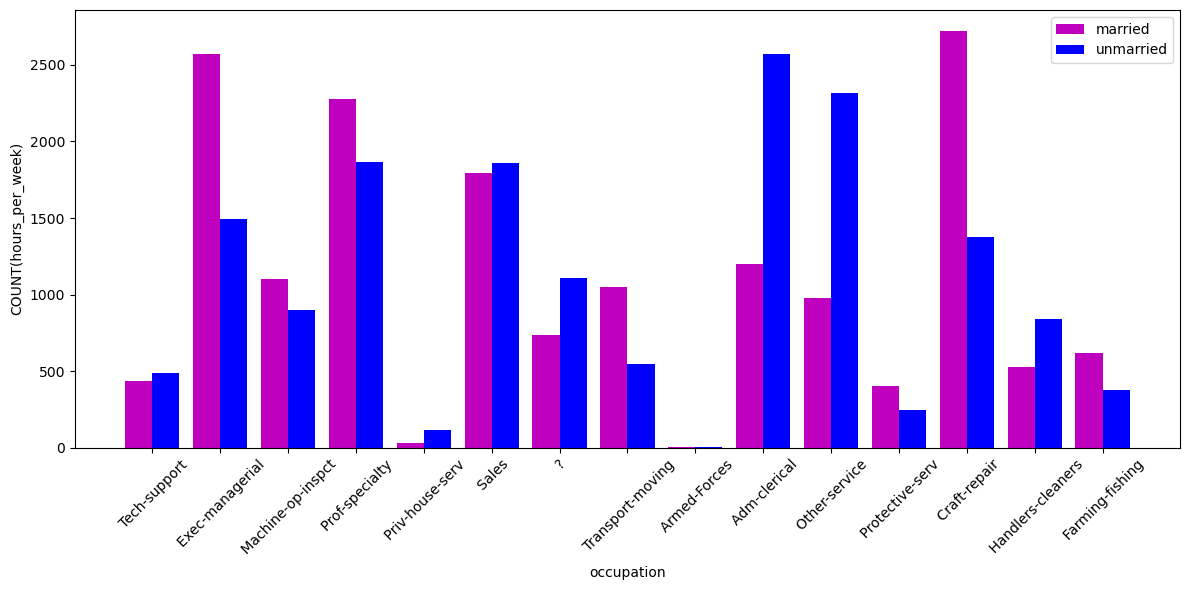

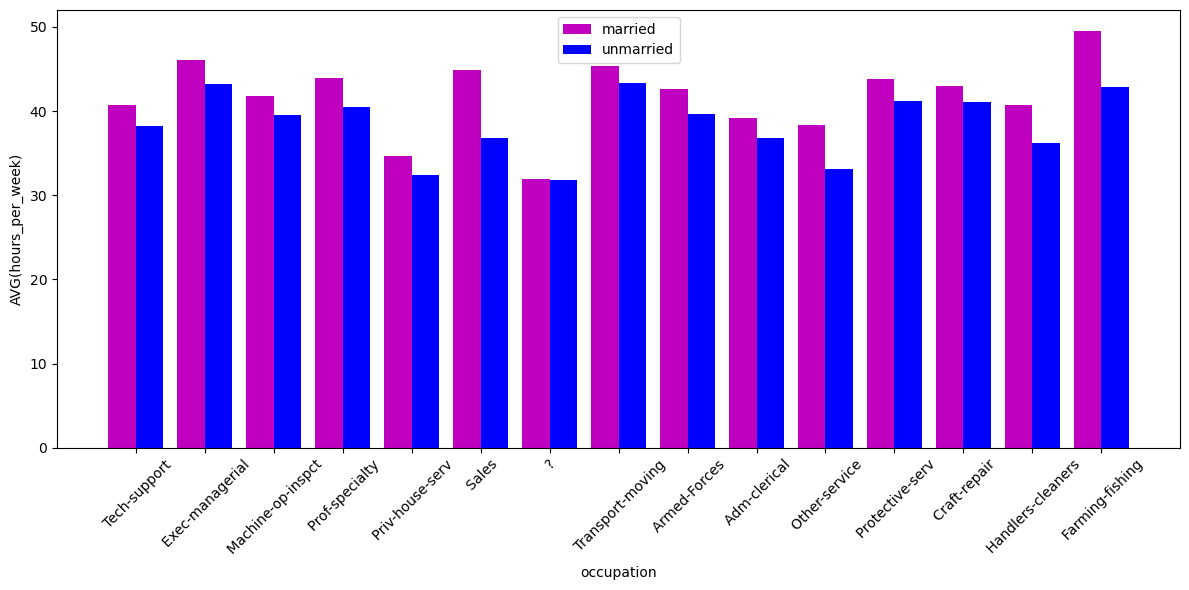

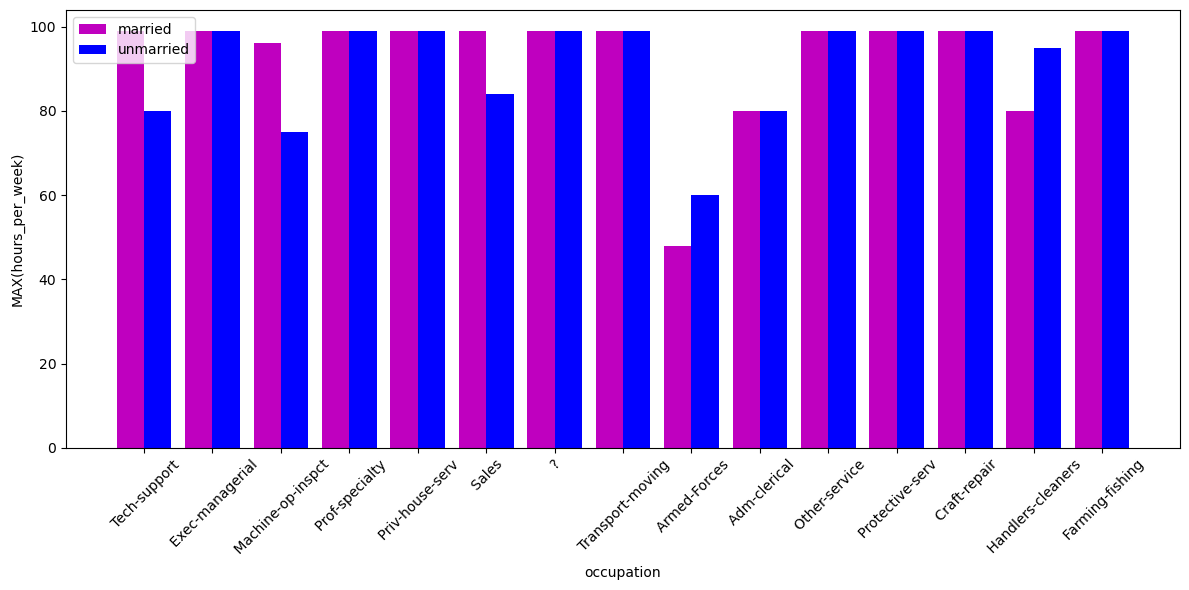

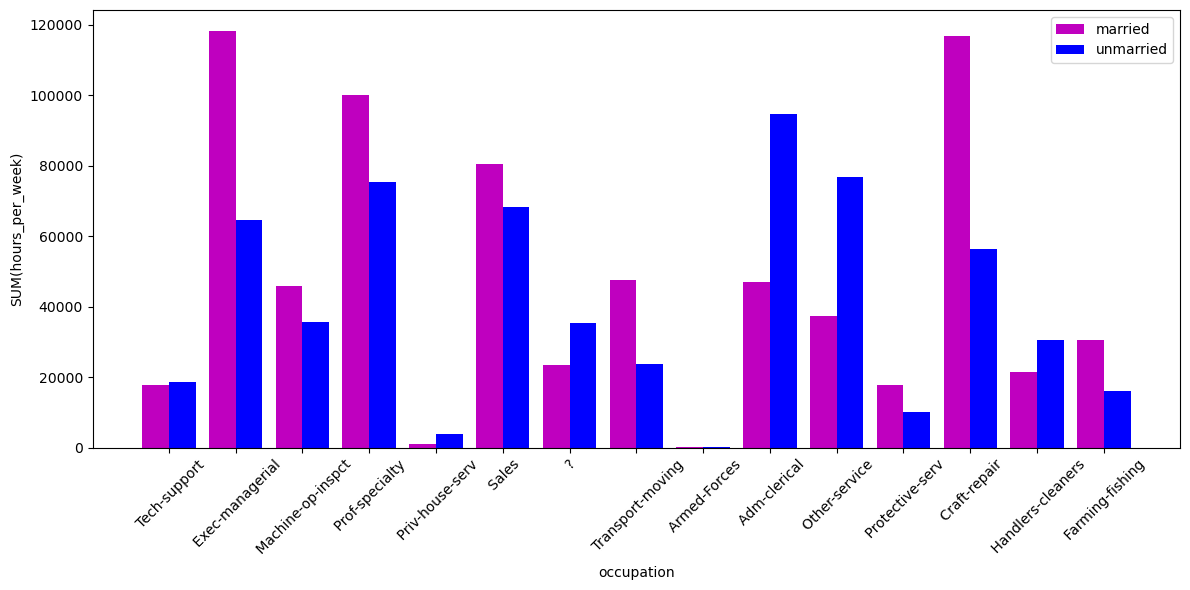

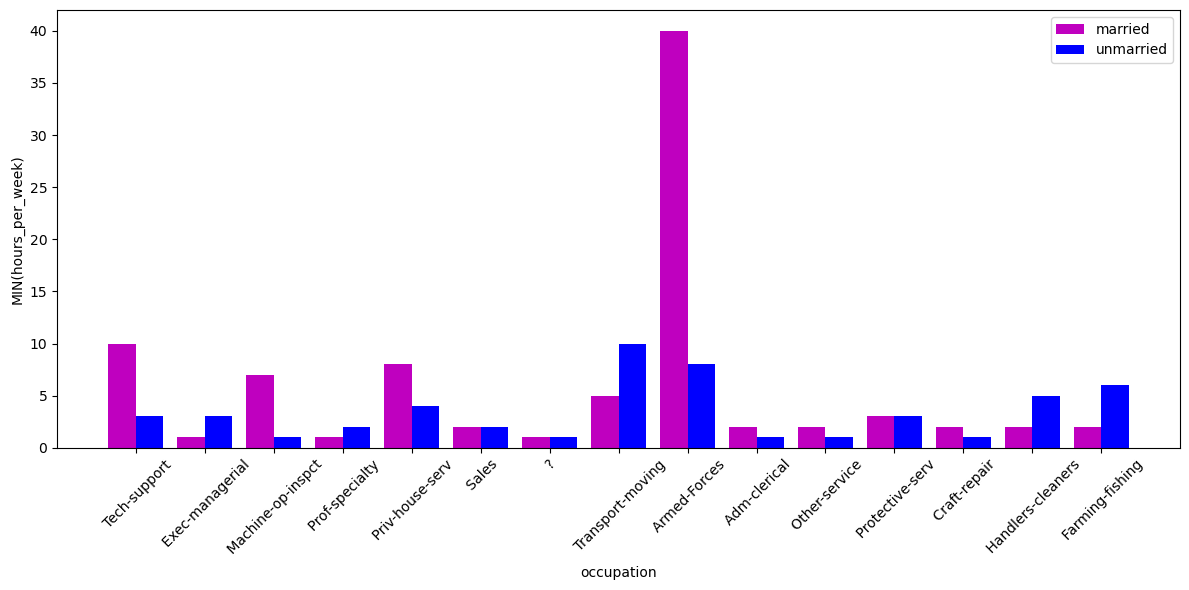

In [142]:
top_k_views_bruteforce()

In [137]:
top_k_views()

C:\Users\ljm14\AppData\Local\Temp\ipykernel_8204\521567807.py:120: RuntimeWarning: divide by zero encountered in log
  err_bound = np.sqrt((1-(phase-1)/maxphase)*(2*np.log(np.log(phase))) + np.log((np.pi**2)/(3*delta)))
C:\Users\ljm14\AppData\Local\Temp\ipykernel_8204\521567807.py:120: RuntimeWarning: invalid value encountered in sqrt
  err_bound = np.sqrt((1-(phase-1)/maxphase)*(2*np.log(np.log(phase))) + np.log((np.pi**2)/(3*delta)))


NameError: name 'v_lowbound' is not defined

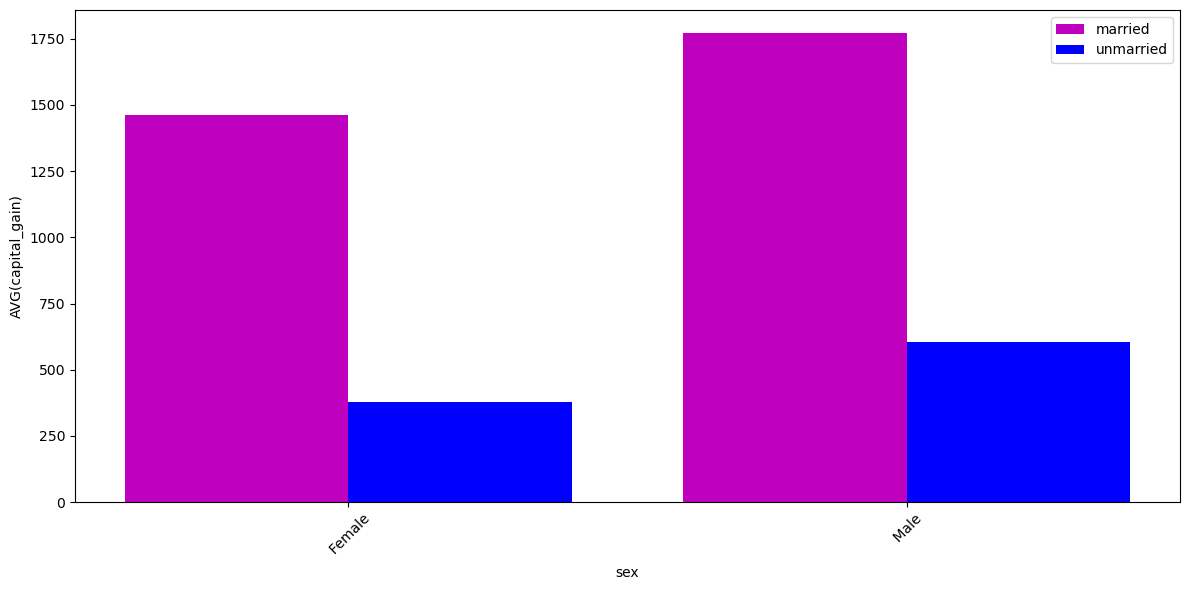

In [65]:
# reproduce "interesting" bar graph from figure 1.c
# married target data - avg capital_gain by sex
query = "SELECT sex, avg(capital_gain) FROM married GROUP BY sex;"
cur.execute(query)
target = cur.fetchall()

# unmarried ref data - avg capital_gain by sex
query = "SELECT sex, avg(capital_gain) FROM unmarried GROUP BY sex;"
cur.execute(query)
ref = cur.fetchall()

params = ('sex', 'capital_gain', 'AVG')
visualize(dict(target), dict(ref), params)

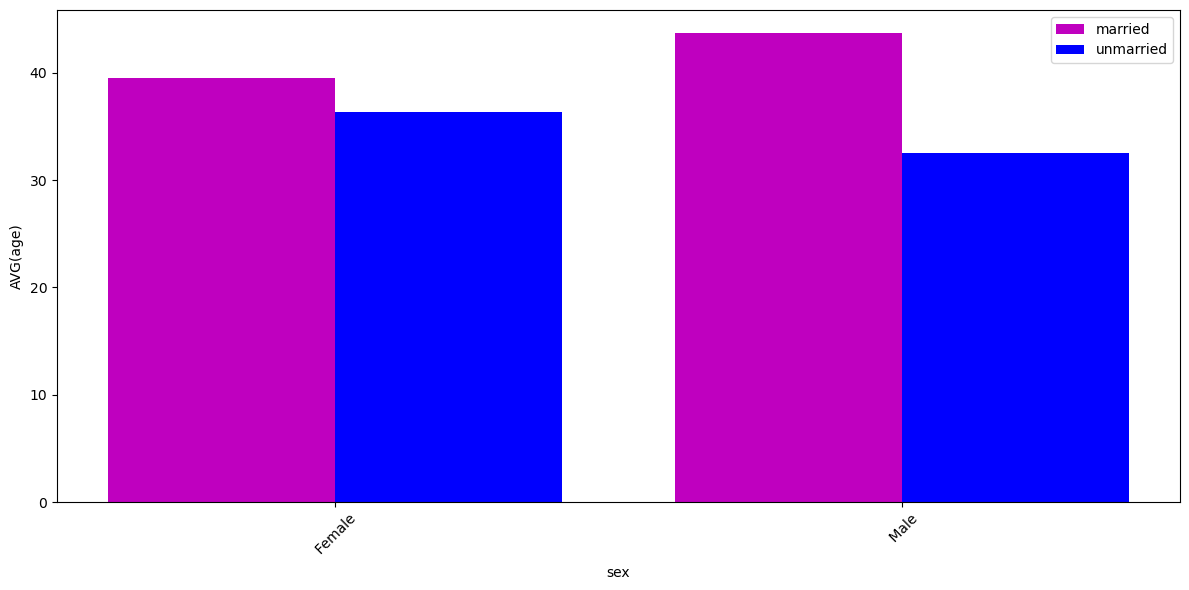

In [66]:
# reproduce "uninteresting" bar graph from figure 1.d
# married target data - avg capital_gain by sex
query = "SELECT sex, avg(age) FROM married GROUP BY sex;"
cur.execute(query)
target = cur.fetchall()

# unmarried ref data - avg capital_gain by sex
query = "SELECT sex, avg(age) FROM unmarried GROUP BY sex;"
cur.execute(query)
ref = cur.fetchall()

params = ('sex', 'age', 'AVG')
visualize(dict(target), dict(ref), params)